Fitting 5 folds for each of 600 candidates, totalling 3000 fits


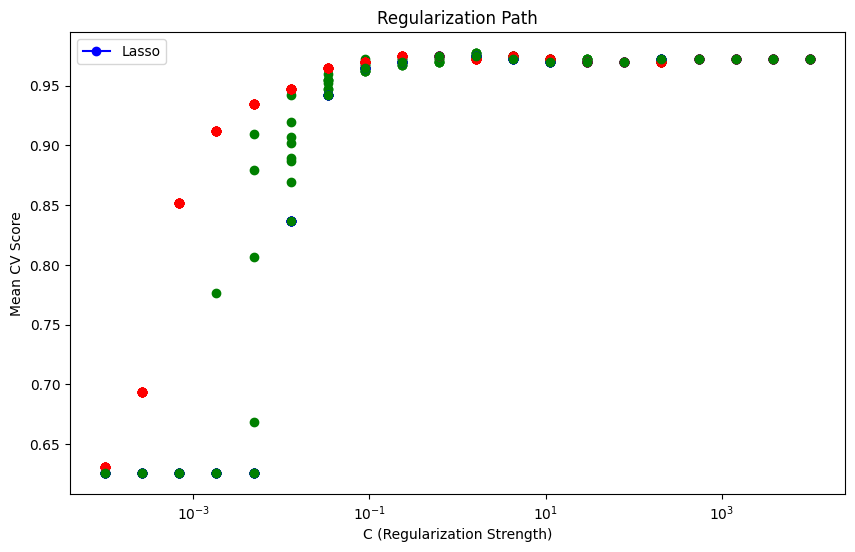

({'logreg__C': 1.623776739188721,
  'logreg__l1_ratio': 0.4444444444444444,
  'logreg__penalty': 'elasticnet'},
 0.9773101265822784)

In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt

# Cargar los datos del cáncer de mama
data = load_breast_cancer()
X, y = data.data, data.target

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Crear una pipeline que incluya la estandarización de los datos y el modelo de regresión logística
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(solver='saga', max_iter=10000))
])

# Definir los valores de los hiperparámetros para probar
param_grid = {
    'logreg__C': np.logspace(-4, 4, 20),
    'logreg__penalty': ['l1', 'l2', 'elasticnet'],
    'logreg__l1_ratio': np.linspace(0, 1, 10)
}

# Usar GridSearchCV para encontrar los mejores hiperparámetros
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')

# Entrenar el modelo con el conjunto de entrenamiento
grid_search.fit(X_train, y_train)

# Resultados de los mejores parámetros
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Preparar datos para la gráfica
results = grid_search.cv_results_
scores_mean = results['mean_test_score']
scores_std = results['std_test_score']
params = results['params']

# Graficar los resultados
plt.figure(figsize=(10, 6))

for i, param in enumerate(params):
    if param['logreg__penalty'] == 'l1':
        plt.plot(param['logreg__C'], scores_mean[i], 'bo-', label='Lasso' if i == 0 else "")
    elif param['logreg__penalty'] == 'l2':
        plt.plot(param['logreg__C'], scores_mean[i], 'ro-', label='Ridge' if i == 0 else "")
    elif param['logreg__penalty'] == 'elasticnet':
        plt.plot(param['logreg__C'], scores_mean[i], 'go-', label='Elastic Net' if i == 0 else "")

plt.xlabel('C (Regularization Strength)')
plt.ylabel('Mean CV Score')
plt.title('Regularization Path')
plt.legend()
plt.xscale('log')
plt.show()

best_params, best_score



In [2]:
# Ajustar el mejor modelo encontrado
best_C = best_params['logreg__C']
best_l1_ratio = best_params['logreg__l1_ratio']
best_penalty = best_params['logreg__penalty']

# Crear un nuevo modelo con los mejores hiperparámetros
best_model = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(solver='saga', max_iter=10000, C=best_C, penalty=best_penalty, l1_ratio=best_l1_ratio))
])

# Entrenar el modelo con todo el conjunto de entrenamiento
best_model.fit(X_train, y_train)

# Evaluar el modelo en el conjunto de prueba
test_accuracy = best_model.score(X_test, y_test)

print(f"Accuracy en el conjunto de prueba: {test_accuracy}")


Accuracy en el conjunto de prueba: 0.9824561403508771


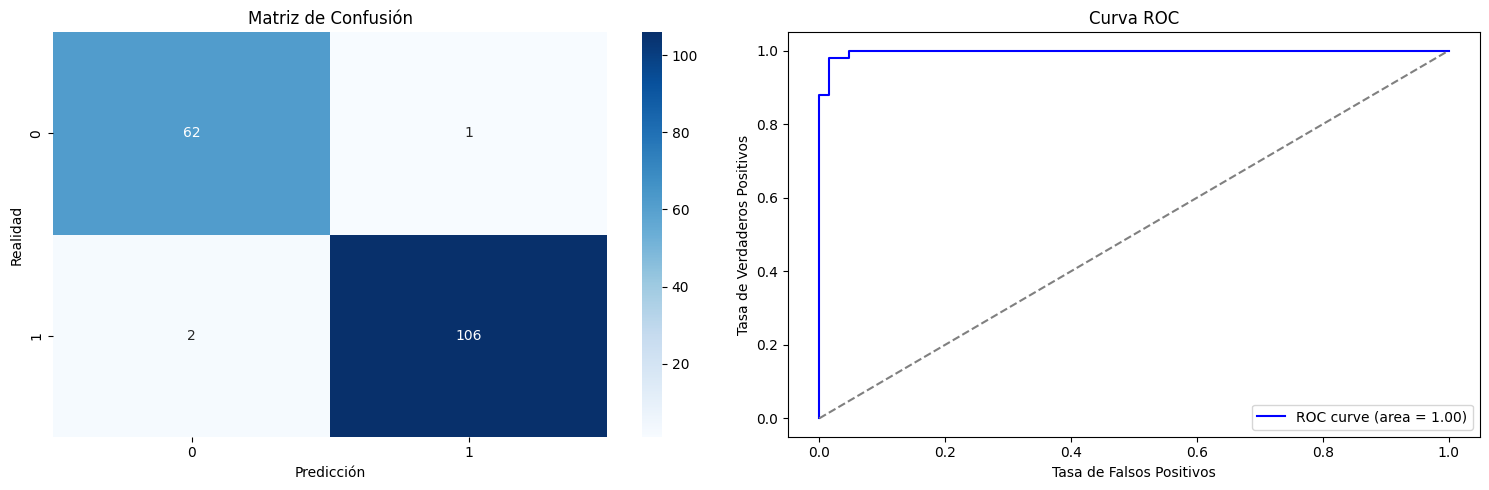

'              precision    recall  f1-score   support\n\n   malignant       0.97      0.98      0.98        63\n      benign       0.99      0.98      0.99       108\n\n    accuracy                           0.98       171\n   macro avg       0.98      0.98      0.98       171\nweighted avg       0.98      0.98      0.98       171\n'

In [3]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import seaborn as sns

# Predecir en el conjunto de prueba usando el mejor modelo encontrado
y_pred = best_model.predict(X_test)

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Cálculo de la curva ROC y AUC
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Crear gráficas
plt.figure(figsize=(15, 5))

# Graficar la matriz de confusión
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Realidad')

# Graficar la curva ROC
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Curva ROC')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()


In [5]:

# Reporte de clasificación (incluye sensibilidad, especificidad, F1-score)
report = classification_report(y_test, y_pred, target_names=data.target_names)
print(report)



              precision    recall  f1-score   support

   malignant       0.97      0.98      0.98        63
      benign       0.99      0.98      0.99       108

    accuracy                           0.98       171
   macro avg       0.98      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171



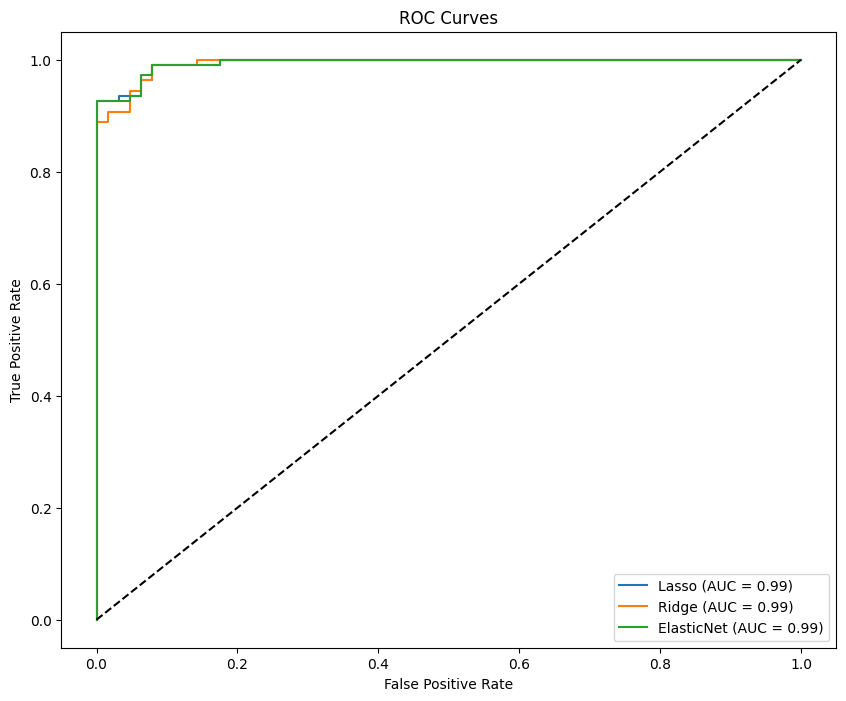

Classification Report for Lasso:
               precision    recall  f1-score   support

           0       0.98      0.90      0.94        63
           1       0.95      0.99      0.97       108

    accuracy                           0.96       171
   macro avg       0.96      0.95      0.96       171
weighted avg       0.96      0.96      0.96       171

Classification Report for Ridge:
               precision    recall  f1-score   support

           0       0.98      0.92      0.95        63
           1       0.96      0.99      0.97       108

    accuracy                           0.96       171
   macro avg       0.97      0.96      0.96       171
weighted avg       0.97      0.96      0.96       171

Classification Report for ElasticNet:
               precision    recall  f1-score   support

           0       0.98      0.90      0.94        63
           1       0.95      0.99      0.97       108

    accuracy                           0.96       171
   macro avg       0.

In [9]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score

# Creamos tres modelos de regresión logística, uno para cada tipo de regularización
model_lasso = LogisticRegressionCV(Cs=10, cv=5, penalty='l1', solver='saga', max_iter=10000, random_state=42)
model_ridge = LogisticRegressionCV(Cs=10, cv=5, penalty='l2', solver='saga', max_iter=10000, random_state=42)
model_elasticnet = LogisticRegressionCV(Cs=10, cv=5, penalty='elasticnet', l1_ratios=[0.1, 0.5, 0.9],
                                        solver='saga', max_iter=10000, random_state=42)

# Ajustamos los modelos al conjunto de entrenamiento
model_lasso.fit(X_train, y_train)
model_ridge.fit(X_train, y_train)
model_elasticnet.fit(X_train, y_train)

# 1. Obtener los mejores parámetros
best_C_lasso = model_lasso.C_[0]  # Asume que model_lasso es una instancia de LogisticRegressionCV
best_C_ridge = model_ridge.C_[0]
best_C_elasticnet = model_elasticnet.C_[0]

# Predecimos las probabilidades en el conjunto de prueba para cada modelo
y_pred_proba_lasso = model_lasso.predict_proba(X_test)[:, 1]
y_pred_proba_ridge = model_ridge.predict_proba(X_test)[:, 1]
y_pred_proba_elasticnet = model_elasticnet.predict_proba(X_test)[:, 1]


# Calculamos AUC para cada modelo
auc_lasso = roc_auc_score(y_test, y_pred_proba_lasso)
auc_ridge = roc_auc_score(y_test, y_pred_proba_ridge)
auc_elasticnet = roc_auc_score(y_test, y_pred_proba_elasticnet)
# Mostramos los resultados
(auc_lasso, auc_ridge, auc_elasticnet)


# 2. Mostrar las curvas ROC
def plot_roc_curve(y_test, y_pred_proba, model_name):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.2f})')

plt.figure(figsize=(10, 8))
plot_roc_curve(y_test, y_pred_proba_lasso, 'Lasso')
plot_roc_curve(y_test, y_pred_proba_ridge, 'Ridge')
plot_roc_curve(y_test, y_pred_proba_elasticnet, 'ElasticNet')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()


# 3. Reporte de Clasificación
print('Classification Report for Lasso:\n', classification_report(y_test, model_lasso.predict(X_test)))
print('Classification Report for Ridge:\n', classification_report(y_test, model_ridge.predict(X_test)))
print('Classification Report for ElasticNet:\n', classification_report(y_test, model_elasticnet.predict(X_test)))


In [10]:
print(f"Mejor C para Ridge: {best_C_ridge}")

0.046415888336127774

In [11]:
# Mejor valor de C para Lasso
print(f"Mejor C para Lasso: {best_C_lasso}")

Mejor C para Lasso: 0.046415888336127774


In [12]:
# Mejor valor de C y l1_ratio para ElasticNet
best_C_elasticnet = model_elasticnet.C_[0]
best_l1_ratio_elasticnet = model_elasticnet.l1_ratio_[0]
print(f"Mejor C para ElasticNet: {best_C_elasticnet}, Mejor l1_ratio: {best_l1_ratio_elasticnet}")

Mejor C para ElasticNet: 0.005994842503189409, Mejor l1_ratio: 0.1


Mejor C para Lasso: 166.81005372000558
Mejor C para Ridge: 2.782559402207126
Mejor C para ElasticNet: 2.782559402207126, Mejor l1_ratio: 0.1


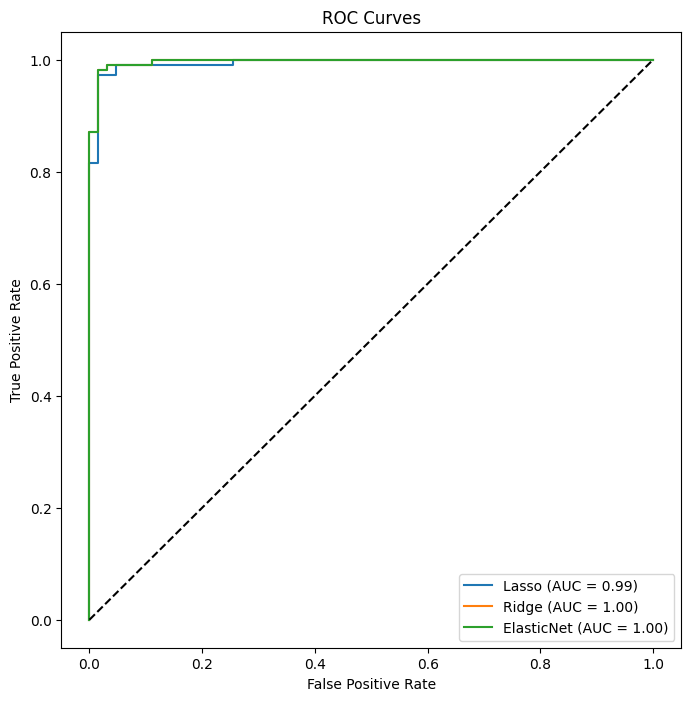

Classification Report for Lasso:
               precision    recall  f1-score   support

           0       0.95      0.98      0.97        63
           1       0.99      0.97      0.98       108

    accuracy                           0.98       171
   macro avg       0.97      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171

Classification Report for Ridge:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98        63
           1       0.99      0.98      0.99       108

    accuracy                           0.98       171
   macro avg       0.98      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171

Classification Report for ElasticNet:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98        63
           1       0.99      0.98      0.99       108

    accuracy                           0.98       171
   macro avg       0.

In [15]:
from sklearn.preprocessing import StandardScaler

# Estandarizar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reajustar los modelos con los datos estandarizados
model_lasso.fit(X_train_scaled, y_train)
model_ridge.fit(X_train_scaled, y_train)
model_elasticnet.fit(X_train_scaled, y_train)


# Mejor valor de C para Lasso
best_C_lasso = model_lasso.C_[0]
print(f"Mejor C para Lasso: {best_C_lasso}")

# Mejor valor de C para Ridge
best_C_ridge = model_ridge.C_[0]
print(f"Mejor C para Ridge: {best_C_ridge}")

# Mejor valor de C y l1_ratio para ElasticNet
best_C_elasticnet = model_elasticnet.C_[0]
best_l1_ratio_elasticnet = model_elasticnet.l1_ratio_[0]
print(f"Mejor C para ElasticNet: {best_C_elasticnet}, Mejor l1_ratio: {best_l1_ratio_elasticnet}")

# Predecir las probabilidades en el conjunto de prueba estandarizado para cada modelo
y_pred_proba_lasso_scaled = model_lasso.predict_proba(X_test_scaled)[:, 1]
y_pred_proba_ridge_scaled = model_ridge.predict_proba(X_test_scaled)[:, 1]
y_pred_proba_elasticnet_scaled = model_elasticnet.predict_proba(X_test_scaled)[:, 1]

# Calcular AUC para cada modelo con datos estandarizados
auc_lasso_scaled = roc_auc_score(y_test, y_pred_proba_lasso_scaled)
auc_ridge_scaled = roc_auc_score(y_test, y_pred_proba_ridge_scaled)
auc_elasticnet_scaled = roc_auc_score(y_test, y_pred_proba_elasticnet_scaled)

# Mostrar los resultados
(auc_lasso_scaled, auc_ridge_scaled, auc_elasticnet_scaled)

# 2. Mostrar las curvas ROC
def plot_roc_curve(y_test, y_pred_proba, model_name):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.2f})')

plt.figure(figsize=(8, 8))
plot_roc_curve(y_test, y_pred_proba_lasso_scaled, 'Lasso')
plot_roc_curve(y_test, y_pred_proba_ridge_scaled, 'Ridge')
plot_roc_curve(y_test, y_pred_proba_elasticnet_scaled, 'ElasticNet')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

#Reporte de Clasificación
print('Classification Report for Lasso:\n', classification_report(y_test, model_lasso.predict(X_test_scaled)))
print('Classification Report for Ridge:\n', classification_report(y_test, model_ridge.predict(X_test_scaled)))
print('Classification Report for ElasticNet:\n', classification_report(y_test, model_elasticnet.predict(X_test_scaled)))
